In [1]:
'''
Camera and Force measurement of electrohydraulic balloon actuator
Created on 2021.10.07 based on 'BipolarDataAnalysis.ipynb'
'''

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

from nptdms import TdmsFile

# %matplotlib notebook
# %matplotlib notebook
plt.rcParams.update({'font.size': 14})

Fs = 1000

dataPath = ".\Data1007 CamForceNoFluidGauge"

subFolder = ["SiliconeOil_MedTube","SiliconeOil_Tube8mm","FR3_MedTube","FR3_Tube8mm","FR3_Tube8mmRotated"]

calib = np.loadtxt('Calibration20210802.txt')
print("Calibration line a = %.16f, b = %.16f" % (calib[0],calib[1]))

Calibration line a = 0.0497649079931161, b = 0.1217075926746309


In [2]:
'''
General Functions
'''

def aPlot(figName, is3D = False):
    ax = []
    
    fig1 = plt.figure(figsize = (14,4))
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax

Baloon4_2, max-force. = 0.908 N (length = 7974)
Baloon4_3, max-force. = 0.610 N (length = 9248)
Baloon4_4, max-force. = 0.531 N (length = 10350)
Baloon4_5, max-force. = 0.696 N (length = 8108)
Baloon4_6, max-force. = 0.604 N (length = 7496)
.\Data1007 CamForceNoFluidGauge\FR3_MedTube - Condition: 
FR3MedTubeU6900V
trial01, mean-pres. = -0.005 bar, max-pres. = 0.004 bar (length = 2200)
.\Data1007 CamForceNoFluidGauge\FR3_MedTube - Condition: 
FR3MedTubeU6900V
trial02, mean-pres. = -0.006 bar, max-pres. = 0.003 bar (length = 2200)
.\Data1007 CamForceNoFluidGauge\FR3_MedTube - Condition: 
FR3MedTubeU6900V
trial03, mean-pres. = -0.007 bar, max-pres. = 0.004 bar (length = 2200)
.\Data1007 CamForceNoFluidGauge\FR3_MedTube - Condition: 
FR3MedTubeU6900V
trial04, mean-pres. = -0.005 bar, max-pres. = 0.004 bar (length = 2200)
.\Data1007 CamForceNoFluidGauge\FR3_MedTube - Condition: 
FR3MedTubeU6900V
trial05, mean-pres. = -0.006 bar, max-pres. = 0.004 bar (length = 2200)
Baloon5_2, max-force. = 

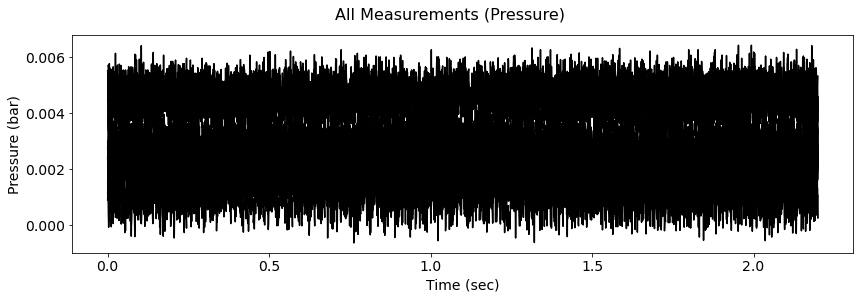

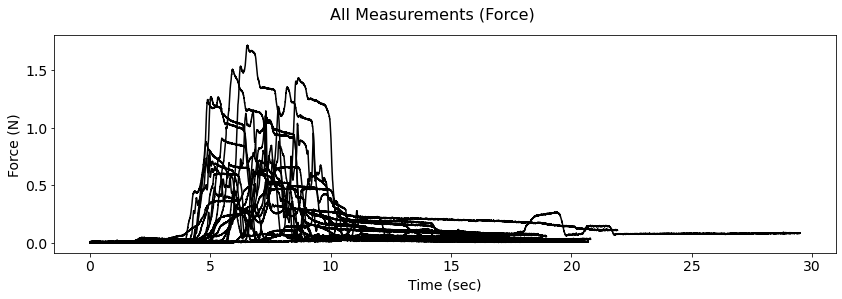

In [3]:
'''
Import data from csv files
'''

ax = aPlot('All Measurements (Pressure)')
ax2 = aPlot('All Measurements (Force)')

start_ind = ((np.array([1]) - 0.1) * Fs).astype(int)
end_ind = ((np.array([3]) + 0.1) * Fs).astype(int)

presData = []
forceData = []
for root, directories, files in walk(dataPath):
    for fileName in files:
        # Reading in csv (Fluid pressure sensor and control reference signal)
        if (fileName[-3:] == 'csv'):
            condi = re.split('_|\.csv', fileName)[3:5]
            names = condi[0]

            trialNum = int(re.split('t', condi[1])[-1])

            data = np.genfromtxt(ospa.join(root, fileName), delimiter=',')
            data = data[start_ind[0]:end_ind[0],:]

            dataLen = len(data[:,0])

            ax.plot(np.arange(dataLen)/Fs, (data[:,1]-calib[1])*calib[0], color = 'k')       

            meanVoltage = np.mean(data[int(dataLen/2):,1]) - data[0,1]     
            meanPressure = (meanVoltage-calib[1])*calib[0]

            maxVoltage = np.max(data[:,1]) - np.min(data[:,1]);
            maxPressure = maxVoltage*calib[0]

            print("%s - Condition: " % root)
            print(names)
            print("trial%02d, mean-pres. = %.3f bar, max-pres. = %.3f bar (length = %d)" % 
                  (trialNum, meanPressure, maxPressure, dataLen))

            presData.append([names, trialNum, meanPressure, maxPressure])
        # Reading in tdms (Force sensor, time and LED signal)
        if (fileName[-4:] == 'tdms'):
            with TdmsFile.open(ospa.join(root, fileName)) as tdms_file:
                sensorData = tdms_file['FT sensor']
                
                temp = sensorData['Fx']
                FxData = temp[:]
                temp = sensorData['Fy']
                FyData = temp[:]
                temp = sensorData['Fz']
                FzData = temp[:]
                
                temp = sensorData['Time']
                tForce = temp[:]
                
                # Remove offset
                FxData = FxData-FxData[0]
                FyData = FyData-FyData[0]
                FzData = FzData-FzData[0]
                tForce = tForce-tForce[0]
                
                # Compute force magnituge
                FAmp = np.sqrt(np.square(FxData) + np.square(FyData) + np.square(FzData))
                dataLen2 = len(FAmp)
                
                maxForceAmp = np.max(FAmp)
                ax2.plot(tForce, FAmp, color = 'k')   
                
                print("%s, max-force. = %.3f N (length = %d)" % (fileName[:-5], maxForceAmp, dataLen2))
                
                forceData.append([fileName[:-5], maxForceAmp])
        
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Pressure (bar)')
ax2.set_xlabel('Time (sec)')
ax2.set_ylabel('Force (N)')
        
presData = pd.DataFrame(presData, columns = ['Condition','Trial','MeanPressure','MaxPressure'])
forceData = pd.DataFrame(forceData, columns = ['ConditionKey','MaxForce'])

presData = pd.concat([presData, forceData], axis = 1)

In [4]:
condiNames = pd.unique(presData['Condition'])
condiNum = len(condiNames)
print("In total %d conditions: %s" % (condiNum, condiNames))


In total 4 conditions: ['FR3MedTubeU6900V' 'FR3Tube8mmU6900V' 'SiMedTubeU6900V' 'SiTube8mmU6900V']


In [5]:
# select_ind = (presData['Trial'] > 0) & (presData['Trial'] < 6) 
select_ind = (presData['Trial'] > 0)
# for condi in condiNames:
#     condiAvgMax = np.mean(presData.loc[(presData['Condition'] == condi) & select_ind, 'MaxPressure'])
#     print("%s - avg. max pressure = %.3f bar" % (condi, condiAvgMax))
# print("-------------------------------------")

for condi in condiNames:
    condiMaxMax = np.max(presData.loc[presData['Condition'] == condi, 'MaxPressure'])
    condiMaxMax2 = np.max(presData.loc[presData['Condition'] == condi, 'MaxForce'])
    print("%s - max pressure = %.3f bar, max force = %.3f N" % (condi, condiMaxMax, condiMaxMax2))

FR3MedTubeU6900V - max pressure = 0.004 bar, max force = 0.908 N
FR3Tube8mmU6900V - max pressure = 0.004 bar, max force = 0.368 N
SiMedTubeU6900V - max pressure = 0.003 bar, max force = 1.714 N
SiTube8mmU6900V - max pressure = 0.004 bar, max force = 1.155 N


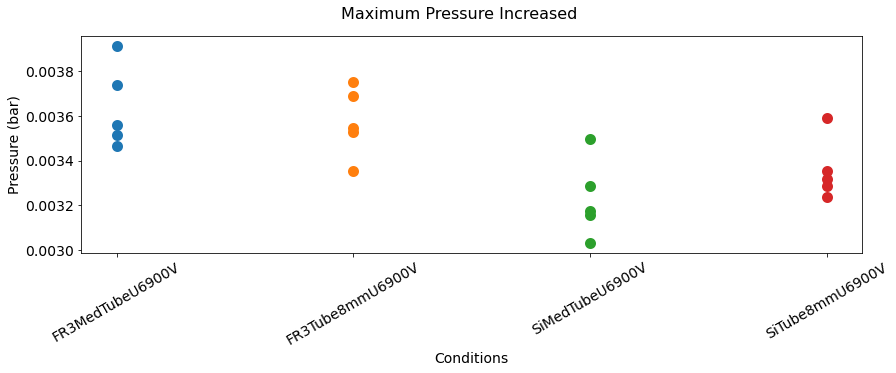

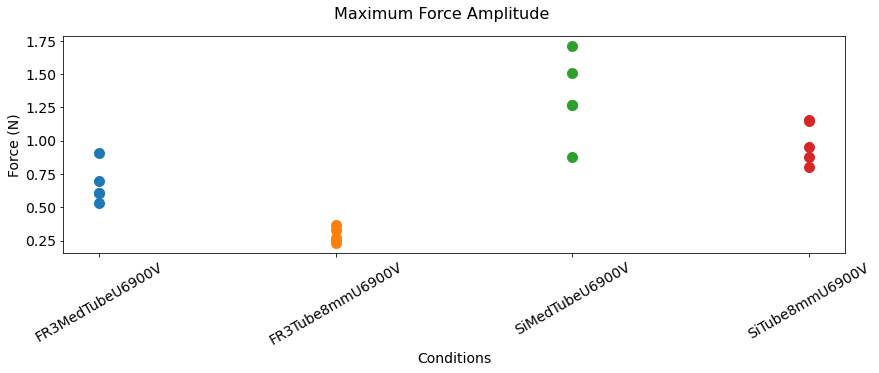

In [6]:
select_ind = (presData['Trial'] > 0)

ax = aPlot('Maximum Pressure Increased')
ax2 = aPlot('Maximum Force Amplitude')
for i in range(condiNum):
    temp = presData.loc[(presData['Condition'] == condiNames[i]) & select_ind, 'MaxPressure']
    ax.scatter(i*np.ones(temp.size), temp, linewidths = 5)
    
    temp = presData.loc[(presData['Condition'] == condiNames[i]) & select_ind, 'MaxForce']
    ax2.scatter(i*np.ones(temp.size), temp, linewidths = 5)
    
ax.set_xticks(range(condiNum))
ax.set_xticklabels(condiNames, rotation=30)
ax.set_xlabel('Conditions')
ax.set_ylabel('Pressure (bar)')

ax2.set_xticks(range(condiNum))
ax2.set_xticklabels(condiNames, rotation=30)
ax2.set_xlabel('Conditions')
ax2.set_ylabel('Force (N)')
plt.show()